<a href="https://colab.research.google.com/github/avfka/itmo-ml-labs-2025/blob/main/lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети

Лабораторная работа посвящена нейронным сетям.

Если кратко, то нейронная сеть - это серия последовательных преобразований, применяемым к входным данным с целью получить выходные данные. Основными операциями являются сложение, умножение, а также применение нелинейных преобразований вроде взятия экспоненты.

С помощью нейронных сетей сейчас успешно решается огромное количество задач.

Самой простой нейронной сетью можно назвать старую добрую линейную регресиию. Чуть более сложной - логистическую регрессию. По сути, логистическая регрессия = линейная регрессия + сигмоида в качестве функции активации.

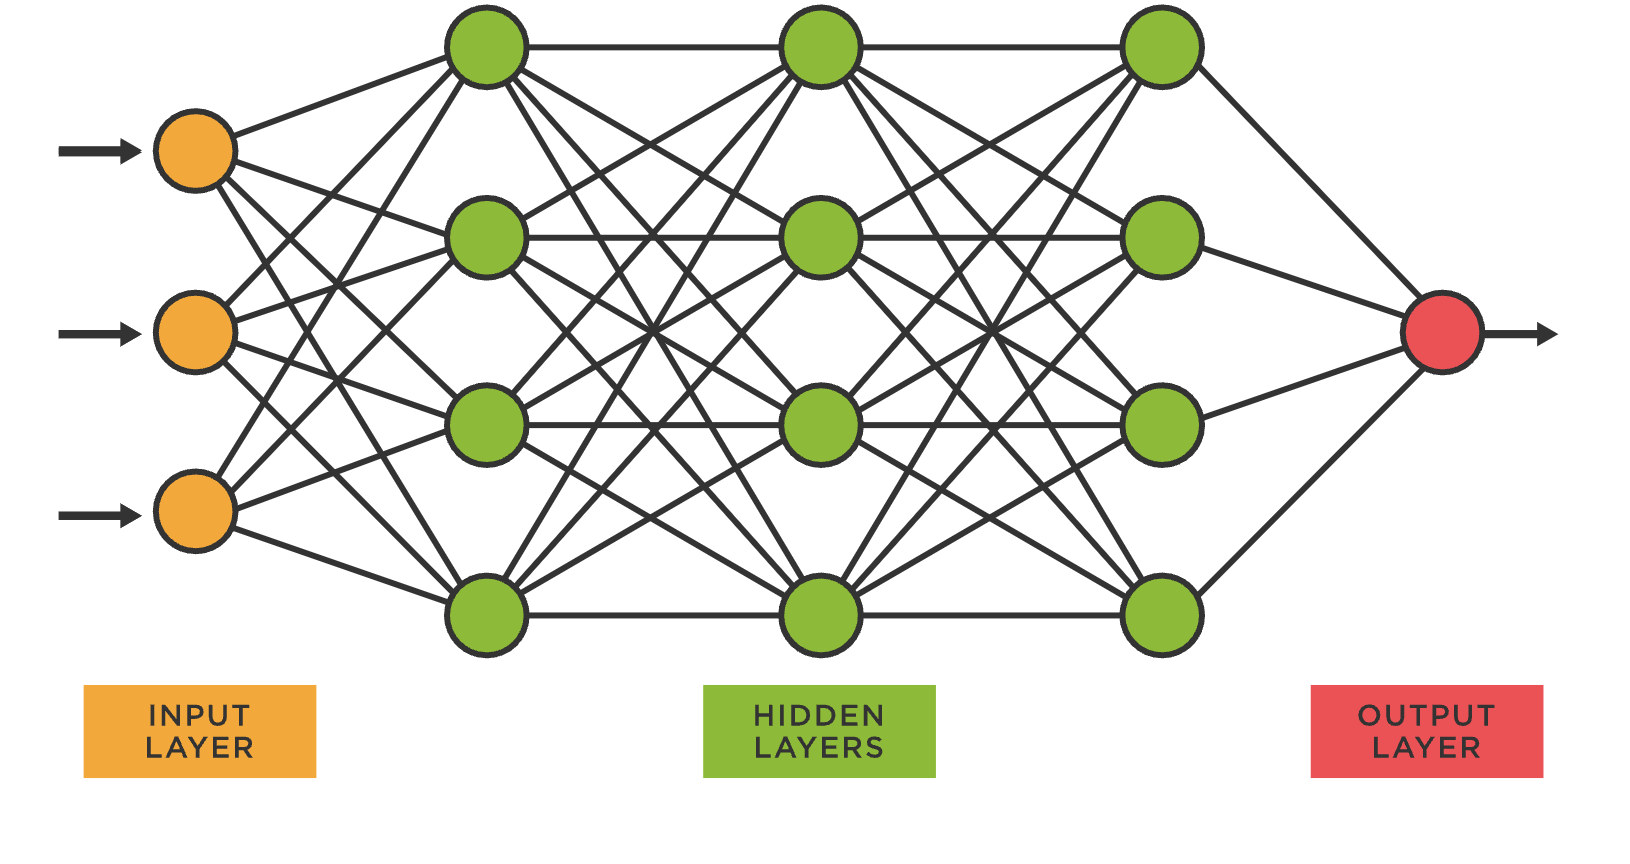

Нейронная сеть состоит из последовательных слоев, каждый слой состоит из нейронов. Входной слой - это исходные данные, выходной - результат, получающийся в результате прямого прохода (forward pass) по нейронной сети.

Каждый нейрон представляет из себя функцию. Мы будем рассматривать нейроны вида $Activation(XW + b)$, где $X$ - входные данные, $W$ и $b$ - настраиваемые параметры сети, $Activation()$ - какое-либо преобразование, совершаемое над результатом $XW + b$. В самом простом случае $Activation()$ == $Identity()$.

Обучаются нейронные сети с помощью алгоритма обратного распространения ошибки (backpropagation). То есть после преобразований мы получаем от нейронной сети какой-то выход, затем с помощью функции потерь оцениваем, насколько он далёк от того, что хотелось бы получить, а потом с помощью градиентного спуска корректируем настраиваемые параметры сети так, чтобы она выдавала более качественные ответы.

При обратном распространении мы идем по сети из конца в начало. Для расчета градиентов на каждом шаге применяется правило цепочки: $\frac{{df}}{{dx}} = \frac{{df}}{{dg}} \cdot \frac{{dg}}{{dx}}$

Выполнять задания лабораторной работы можно последовательно, однако рекомендуется сначала реализовать блок "Операции над матрицами", затем MSE из блока "Функции потерь", после  Identity из блока "Функции активации", затем полносвязную нейронную сеть в её первом приближении. Потом можно доделать все оставшиеся пункты работы.

Дополнительные материалы:

1. Книга [Грокаем глубокое обучение](https://xn--d1ag.xn--e1a4c/tmp/Bibl_progr_Sb_187kn/%D0%93%D1%80%D0%BE%D0%BA%D0%B0%D0%B5%D0%BC%20%D0%B3%D0%BB%D1%83%D0%B1%D0%BE%D0%BA%D0%BE%D0%B5%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5.%202019.pdf), где нейронные сети разбираются буквально на пальцах

2. Онлайн-курс [Введение в искусственные нейронные сети](https://stepik.org/course/100076/syllabus?auth=login) от ОмГТУ

## Операции над матрицами

In [1]:
from copy import deepcopy
import numpy as np

Нейронные сети работают с числами, представленными в виде многомерных массивов данных.

Частным случаем таких массивов являются двумерные матрицы. Вспомним азы математики и реализуем следующие функции:

1. Умножение матрицы на скаляр

2. Сложение матриц

3. Транспонирование матрицы

4. Умножение матриц. Умножать матрицы можно, если число столбцов первой матрицы равно числу строк второй матрицы

При реализации используйте функции и методы для работы со списками, циклы, а также списковые включения. NumPy можно использовать только для проверки корректности работы вашего кода.

In [2]:
def validate_matrix(matrix):
    assert len(matrix) > 0, "Входная матрица не должна быть пустой"
    assert isinstance(matrix, list), "Входная матрица должна быть представлена списком"
    assert all(isinstance(row, list) for row in matrix), "Каждая строка в матрице должна быть списком"
    assert all(len(row) == len(matrix[0]) for row in matrix), "Все строки в матрице должны быть одинаковой длины"


def scalar_multiplication(matrix: list[list[float]], scalar: float,
                         copy: bool = True) -> list[list[float]] | None:
    validate_matrix(matrix)

    if copy:
        return [[element * scalar for element in row] for row in matrix]
    else:
        for row in matrix:
            for i in range(len(row)):
                row[i] *= scalar
        return None


def matrix_addition(matrix1: list[list[float]],
                   matrix2: list[list[float]]) -> list[list[float]]:
    validate_matrix(matrix1)
    validate_matrix(matrix2)

    if len(matrix1) != len(matrix2) or len(matrix1[0]) != len(matrix2[0]):
        raise ValueError("Матрицы должны иметь одинаковые размеры")

    return [
        [matrix1[i][j] + matrix2[i][j] for j in range(len(matrix1[0]))]
        for i in range(len(matrix1))
    ]


def matrix_transposition(matrix: list[list[float]]) -> list[list[float]]:
    validate_matrix(matrix)

    return [
        [matrix[j][i] for j in range(len(matrix))]
        for i in range(len(matrix[0]))
    ]


def matrix_multiplication(matrix1: list[list[float]],
                         matrix2: list[list[float]]) -> list[list[float]]:
    validate_matrix(matrix1)
    validate_matrix(matrix2)

    if len(matrix1[0]) != len(matrix2):
        raise ValueError(
            "Количество столбцов первой матрицы должно быть равно количеству строк второй матрицы")

    result = [[0 for _ in range(len(matrix2[0]))] for _ in range(len(matrix1))]

    for i in range(len(matrix1)):
        for j in range(len(matrix2[0])):
            for k in range(len(matrix2)):
                result[i][j] += matrix1[i][k] * matrix2[k][j]

    return result

In [3]:
def print_matrix(matrix):
  for row in matrix:
      print(row)


matrix1 = [[1, 2, 3],
           [4, 5, 6],
           [7, 8, 9]]

matrix2 = [[9, 8, 7],
           [6, 5, 4],
           [3, 2, 1]]

print("Умножение на скаляр:")
print_matrix(scalar_multiplication(matrix1, 2))
print()

print("Сложение матриц:")
print_matrix(matrix_addition(matrix1, matrix2))
print()

print("Произведение матриц:")
print_matrix(matrix_multiplication(matrix1, matrix2))
print()

print("Транспонирование матрицы:")
print_matrix(matrix_transposition(matrix1))
print()

Умножение на скаляр:
[2, 4, 6]
[8, 10, 12]
[14, 16, 18]

Сложение матриц:
[10, 10, 10]
[10, 10, 10]
[10, 10, 10]

Произведение матриц:
[30, 24, 18]
[84, 69, 54]
[138, 114, 90]

Транспонирование матрицы:
[1, 4, 7]
[2, 5, 8]
[3, 6, 9]



Теперь, когда мы вспомнили, как считать, порадуемся, что в NumPy всё уже давно реализовано за нас. В дальнейшей работе будем использовать функционал библиотеки NumPy.

In [4]:
matrix1 = np.array([[1, 2, 3],
                    [4, 5, 6],
                    [7, 8, 9]])

matrix2 = np.array([[9, 8, 7],
                    [6, 5, 4],
                    [3, 2, 1]])

print("Умножение на скаляр:")
print_matrix(matrix1 * 2)
print()

print("Сложение матриц:")
print_matrix(matrix1 + matrix2)
print()

print("Произведение матриц:")
print_matrix(matrix1 @ matrix2)
print()

print("Транспонирование матрицы:")
print_matrix(matrix1.T)
print()

Умножение на скаляр:
[2 4 6]
[ 8 10 12]
[14 16 18]

Сложение матриц:
[10 10 10]
[10 10 10]
[10 10 10]

Произведение матриц:
[30 24 18]
[84 69 54]
[138 114  90]

Транспонирование матрицы:
[1 4 7]
[2 5 8]
[3 6 9]



## Функции активации (3 балла)

In [5]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

Функции активации применяются "поверх" выхода какого-либо слоя, добавляя нелинейность.

Самая базовая функция активации - пороговая (именнно так устроены нейроны в человеческом мозге), но с точки зрения машинного обучения подобная функция неудобна, так как её тяжело дифференцировать, а значить проблематично применить алгоритм обратного распрострянения ошибки через градиентный спуск. Поэтому используют дифференцируемые аналоги.

In [6]:
class ActivationFunction(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Применяет функцию активации к входным значениям.

        Параметры:
        - x: numpy.ndarray, входные значения

        Возвращает:
        - activation: numpy.ndarray, значение активации
        """
        pass

    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """
        Вычисляет градиент активационной функции по отношению к входным значениям.

        Параметры:
        - x: numpy.ndarray, входные значения

        Возвращает:
        - gradient: numpy.ndarray, градиент активационной функции
        """
        pass

### Identity

Самая простая функция активации - это её отсутствие, то есть идентичность.

$ Identity(x) = x $

$ Identity'(x) = \frac{d}{dx} Identity(x) = 1 $


Так как для каждого слоя выходное значение линейно, то они образуют линейную комбинацию, результатом которой является линейная функция. То есть если в сети присутствуют функции активации только вида Identity, то финальная функция активации на последнем слое зависит только от входных значений на первом слое. А это значит, что любое количество слоев может быть заменено всего одним слоем, и, следовательно, нет смысла создавать многослойную сеть.

In [7]:
class Identity(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x  # Возвращает входной массив без изменений

    def grad(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)  # Производная f(x)=x равна 1 для всех x

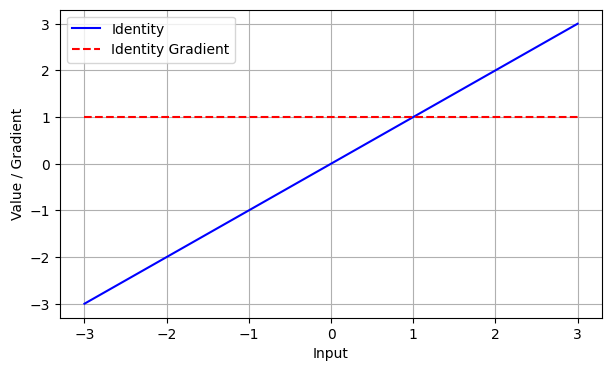

In [8]:
x_range = np.linspace(-3, 3, 1000)

identity = Identity()
values = identity(x_range)
gradient = identity.grad(x_range)

plt.figure(figsize=(7, 4))
plt.plot(x_range, values, label='Identity', c='b')
plt.plot(x_range, gradient, label='Identity Gradient', linestyle='--', c='r')
plt.ylabel('Value / Gradient')
plt.xlabel('Input')
plt.legend()
plt.grid(True)
plt.show()

### Sigmoid

Функция активации Sigmoid - это нелинейная функция, которая преобразует входное значение в диапазон от 0 до 1. Преименяется в задачах бинарной классификации, часто используется на последнем слое нейронной сети. Функция определяется следующим образом:

$
\sigma(x) = \frac{1}{1 + e^{-x}}
$

Самостоятельно рассчитайте градиент функции.


Основной недостаток сигмоиды - проблема затухающих градиентов.

При обратном распространении ошибки в глубоких нейронных сетях могут возникать проблемы с затуханием градиентов из-за плато сигмоидальной функции на концах (см. график функции).

In [9]:
class Sigmoid(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Сигмоидная функция активации"""
        return 1 / (1 + np.exp(-x))

    def grad(self, x: np.ndarray) -> np.ndarray:
        """Производная сигмоидной функции"""
        s = self.__call__(x)  # Вычисляем значение сигмоиды
        return s * (1 - s)    # s' = s * (1 - s)

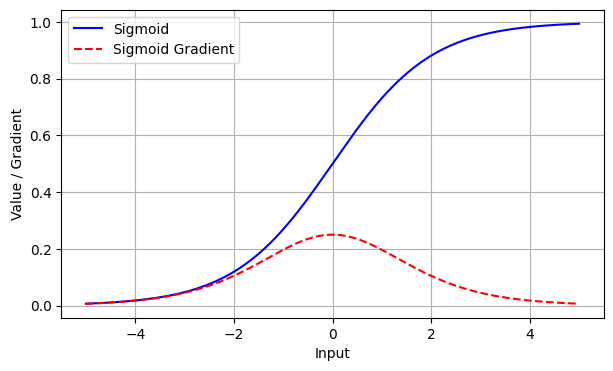

In [10]:
x_range = np.linspace(-5, 5, 1000)

sigmoid = Sigmoid()
values = sigmoid(x_range)
gradient = sigmoid.grad(x_range)

plt.figure(figsize=(7, 4))
plt.plot(x_range, values, label='Sigmoid', c='b')
plt.plot(x_range, gradient, label='Sigmoid Gradient', linestyle='--', c='r')
plt.ylabel('Value / Gradient')
plt.xlabel('Input')
plt.legend()
plt.grid(True)
plt.show()

Сверим свою реализацию с реализацией из PyTorch.

In [11]:
input = np.array([-2, 8, -5, 0.2, 0.1, 3, 7])

custom_output = Sigmoid()(input)
torch_output = F.sigmoid(torch.tensor(input)).numpy()

print("Custom Sigmoid Output:")
print(custom_output)
print()
print("PyTorch Sigmoid Output:")
print(torch_output)

assert np.allclose(custom_output, torch_output)

Custom Sigmoid Output:
[0.11920292 0.99966465 0.00669285 0.549834   0.52497919 0.95257413
 0.99908895]

PyTorch Sigmoid Output:
[0.11920292 0.99966465 0.00669285 0.549834   0.52497919 0.95257413
 0.99908895]


### ReLU

Функция активации ReLU (Rectified Linear Unit) представляет собой простую нелинейную функцию, которая определяется следующим образом:

$
\text{ReLU}(x) = \max(0, x)
$

$
\text{ReLU}'(x) = \begin{cases} 1, & \text{если } x > 0 \\ 0, & \text{если } x \leq 0 \end{cases}
$


**Преимущества ReLU:**

1. Вычисление ReLU очень простое и дешевое с вычислительной точки зрения

2. Обычно приводит к разреженным активациям в нейронной сети, что помогает уменьшить переобучение и улучшить обобщающую способность модели

3. ReLU не подвержена проблеме исчезающего градиента, которая может возникнуть при использовании сигмоидной функции активации

**Недостатки ReLU:**

1. Некоторые нейроны могут "умереть" и всегда выдавать ноль, из-за чего они перестают обновляться в процессе обучения. Это происходит, когда весовые суммы нейронов входят в область отрицательных значений и не активируются. В результате обучения такие нейроны могут оставаться неактивными и не приносить пользы

2. ReLU не центрирована относительно нуля

In [12]:
class ReLU(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Функция ReLU (Rectified Linear Unit)"""
        return np.maximum(0, x)  # Возвращает max(0, x) поэлементно

    def grad(self, x: np.ndarray) -> np.ndarray:
        """Производная ReLU"""
        return (x > 0).astype(float)  # 1 где x > 0, иначе 0

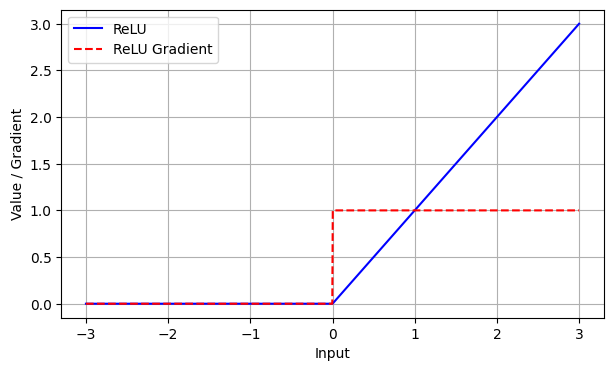

In [13]:
x_range = np.linspace(-3, 3, 1000)

relu = ReLU()
values = relu(x_range)
gradient = relu.grad(x_range)

plt.figure(figsize=(7, 4))
plt.plot(x_range, values, label='ReLU', c='b')
plt.plot(x_range, gradient, label='ReLU Gradient', linestyle='--', c='r')
plt.ylabel('Value / Gradient')
plt.xlabel('Input')
plt.legend()
plt.grid(True)
plt.show()

Сверим свою реализацию с реализацией из PyTorch.

In [14]:
input = np.array([-2, 8, -5, 0.2, 0.1, 3, 7])

custom_output = ReLU()(input)
torch_output = F.relu(torch.tensor(input)).numpy()

print("Custom ReLU Output:")
print(custom_output)
print()
print("PyTorch ReLU Output:")
print(torch_output)

assert np.allclose(custom_output, torch_output)

Custom ReLU Output:
[0.  8.  0.  0.2 0.1 3.  7. ]

PyTorch ReLU Output:
[0.  8.  0.  0.2 0.1 3.  7. ]


Получается, что неактивные нейроны не будут обучаться, так как их веса не будут обновляться при обратном распространении ошибки. Подумайте, может ли это привести к полному прекращению обучения сети ещё до сходимости. Ответьте письменно.

Функция активации ReLU возвращает ноль для всех отрицательных входных значений (x ≤ 0), а её производная в этих точках также равна нулю. Это означает, что:

Если нейрон получает на вход отрицательное значение (например, из-за большого отрицательного смещения или неудачной инициализации весов), он "отключается" (выход = 0).

При обратном распространении ошибки градиент для такого нейрона тоже будет нулевым, и его веса не будут обновляться.

Если это происходит для многих нейронов (особенно в одних и тех же слоях), сеть может потерять способность к обучению.

Если значительная часть нейронов становится "мёртвой", сеть может преждевременно прекратить обучение, так как градиенты для многих весов будут нулевыми.

Необратимость: После "смерти" нейрона маловероятно, что он снова активируется (особенно при фиксированном learning rate), так как обновления весов отсутствуют.

### LeakyReLU

$
\text{LeakyReLU}(x) =
\begin{cases}
x, & \text{если } x > 0 \\
\alpha x, & \text{иначе}
\end{cases}
$

Самостоятельно рассчитайте градиент функции.

$\alpha$ - небольшой положительный коффициент, обычно 0.01.


In [15]:
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha: float = 0.1):
        """
        Инициализирует LeakyReLU с заданным коэффициентом alpha.

        Параметры:
        - alpha: float, коэффициент наклона для отрицательных значений (обычно 0.01-0.3)
        """
        self.alpha = alpha

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Реализация функции LeakyReLU"""
        return np.where(x > 0, x, self.alpha * x)

    def grad(self, x: np.ndarray) -> np.ndarray:
        """Производная LeakyReLU"""
        return np.where(x > 0, 1, self.alpha)

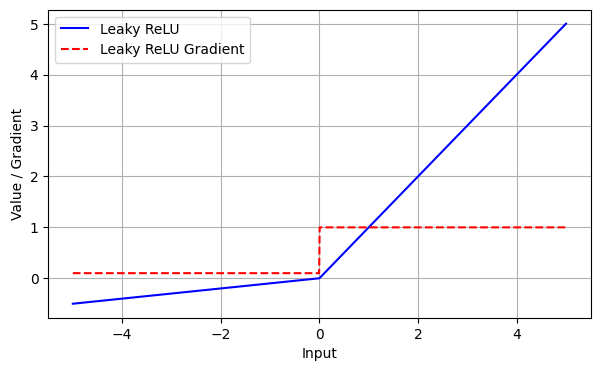

In [16]:
x_range = np.linspace(-5, 5, 1000)

leaky_relu = LeakyReLU(0.1)
values = leaky_relu(x_range)
gradient = leaky_relu.grad(x_range)

plt.figure(figsize=(7, 4))
plt.plot(x_range, values, label='Leaky ReLU', c='b')
plt.plot(x_range, gradient, label='Leaky ReLU Gradient', linestyle='--', c='r')
plt.ylabel('Value / Gradient')
plt.xlabel('Input')
plt.legend()
plt.grid(True)
plt.show()

Сверим свою реализацию с реализацией из PyTorch.

In [17]:
input = np.array([-2, 8, -5, 0.2, 0.1, 3, 7])

custom_output = LeakyReLU(alpha=0.01)(input)
torch_output = F.leaky_relu(torch.tensor(input)).numpy()

print("Custom LeakyReLU Output:")
print(custom_output)
print()
print("PyTorch LeakyReLU Output:")
print(torch_output)

assert np.allclose(custom_output, torch_output)

Custom LeakyReLU Output:
[-0.02  8.   -0.05  0.2   0.1   3.    7.  ]

PyTorch LeakyReLU Output:
[-0.02  8.   -0.05  0.2   0.1   3.    7.  ]


### ELU

Функция потерь ELU (Exponential Linear Unit) выглядит следующим образом:

$
\text{ELU}(x) =
\begin{cases}
x & \text{если } x \geq 0 \\
\alpha (e^x - 1) & \text{если } x < 0
\end{cases}
$

$\alpha$ - небольшой положительный коффициент, обычно 0.01

Самостоятельно рассчитайте градиент функции.

В отличие от ReLU, которая обнуляет все отрицательные значения, ELU сохраняет небольшой градиент для отрицательных значений, что может помочь в предотвращении проблемы "мертвых нейронов", когда нейрон перестаёт обновляться из-за постоянно отрицательного входа.

Однако обратной стороной медали является возрастание вычислительной сложности.

In [18]:
class ELU(ActivationFunction):
    def __init__(self, alpha: float = 1.0):
        """
        Инициализирует ELU с заданным параметром alpha.

        Параметры:
        - alpha: float, определяет значение насыщения для отрицательных входов
        """
        self.alpha = alpha

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Реализация функции ELU"""
        return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))

    def grad(self, x: np.ndarray) -> np.ndarray:
        """Производная функции ELU"""
        return np.where(x > 0, 1, self.__call__(x) + self.alpha)

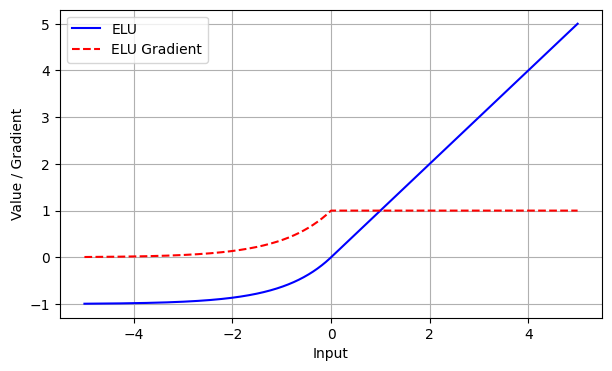

In [19]:
x_range = np.linspace(-5, 5, 1000)

elu = ELU(1)
values = elu(x_range)
gradient = elu.grad(x_range)

plt.figure(figsize=(7, 4))
plt.plot(x_range, values, label='ELU', c='b')
plt.plot(x_range, gradient, label='ELU Gradient', linestyle='--', c='r')
plt.ylabel('Value / Gradient')
plt.xlabel('Input')
plt.legend()
plt.grid(True)
plt.show()

Сверим свою реализацию с реализацией из PyTorch.

In [20]:
input = np.array([-2, 8, -5, 0.2, 0.1, 3, 7])

custom_output = ELU(alpha=1)(input)
torch_output = F.elu(torch.tensor(input)).numpy()

print("Custom ELU Output:")
print(custom_output)
print()
print("PyTorch ELU Output:")
print(torch_output)

assert np.allclose(custom_output, torch_output)

Custom ELU Output:
[-0.86466472  8.         -0.99326205  0.2         0.1         3.
  7.        ]

PyTorch ELU Output:
[-0.86466472  8.         -0.99326205  0.2         0.1         3.
  7.        ]


### Softmax

Функция активации Softmax используется в многоклассовой классификации в нейронных сетях. Она преобразует вектор реальных чисел в вектор вероятностей, где каждый элемент находится в диапазоне от 0 до 1 и сумма всех элементов равна 1.

Говоря более математическим языком, Softmax преобразует входной вектор $z$ в вероятностное распределение через нормализацию экспоненты каждого элемента вектора. Пусть $z$ - входной вектор размерности $(1, p)$, где $p$ - количество классов. Тогда Softmax определяется следующим образом:

$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{p} e^{z_j}} \quad \text{для } i = 1, 2, ..., p
$

Где $z_i$ - i-ый элемент входного вектора $z$.

$
\frac{\partial \text{Softmax}(z_i)}{\partial z_j} = \text{Softmax}(z_i) \cdot (\delta_{ij} - \text{Softmax}(z_j))
$

Где $\delta_{ij}$ - символ Кронекера, который равен 1, если $i = j$, и 0 в противном случае.

Важно отметить, что Softmax не учитывает взаимосвязи между классами и предполагает их независимость.

In [21]:
class Softmax:
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """Вычисляет softmax для входного вектора"""
        # Для численной стабильности вычитаем максимум
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def grad(self, x: np.ndarray) -> np.ndarray:
        """Вычисляет градиент softmax для батча данных"""
        s = self.__call__(x)  # Получаем softmax-активацию
        batch_size = s.shape[0]
        output_size = s.shape[1]

        # Для всех примеров батча сразу вычисляем градиенты
        jacobians = np.array([np.diagflat(s[i]) - np.outer(s[i], s[i]) for i in range(batch_size)])

        return jacobians

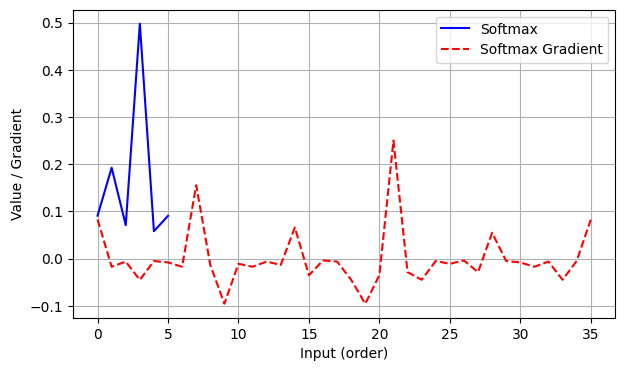

In [22]:
z_range = np.array([[0.5, 1.25, 0.25, 2.2, 0.05, 0.495]])  # просто числа от -inf до +inf, которые нужно превратить в вероятности от 0 до 1

softmax = Softmax()
softmax_values = softmax(z_range)
softmax_gradient = softmax.grad(z_range)

plt.figure(figsize=(7, 4))
plt.plot(softmax_values.flatten(), label='Softmax', c='b')
plt.plot(softmax_gradient.flatten(), label='Softmax Gradient', linestyle='--', c='r')
plt.xlabel('Input (order)')
plt.ylabel('Value / Gradient')
plt.legend()
plt.grid(True)
plt.show()

Сверим свою реализацию с реализацией из PyTorch.

In [23]:
input = np.array([[1.0, 2.0, 3.0],
                  [2.0, 7.0, 4.0],
                  [2.0, 2.0, 2.0]])

custom_output = Softmax()(input)
torch_output = F.softmax(torch.tensor(input), dim=-1).numpy()

print("Custom Softmax Output:")
print(custom_output)
print()
print("PyTorch Softmax Output:")
print(torch_output)

assert np.allclose(custom_output, torch_output)

Custom Softmax Output:
[[0.09003057 0.24472847 0.66524096]
 [0.00637746 0.94649912 0.04712342]
 [0.33333333 0.33333333 0.33333333]]

PyTorch Softmax Output:
[[0.09003057 0.24472847 0.66524096]
 [0.00637746 0.94649912 0.04712342]
 [0.33333333 0.33333333 0.33333333]]


**Примечание**

Сигмоида и Softmax чаще используются именно на выходном слое нейросети в задачах классификации - ими предсказывают вероятности принадлежности объектов к одному из классов, в то время как остальные рассмотренные функции активации используются внутри нейросети, то есть в скрытых слоях.

## Функции потерь (3 балла)

Функции потерь (loss functions) в нейронных сетях, как и в любых других алгоритмах машинного обучения, представляют собой метрики, которые используются для оценки того, насколько хорошо модель выполняет свою задачу во время обучения. Они измеряют расхождение между предсказанными значениями модели и фактическими значениями (целевыми), которые она пытается предсказать. Функции потерь выражаются в виде числового значения, которое показывает, насколько сильно модель ошибается на конкретном наборе данных.

Выбор правильной функции потерь зависит от типа задачи, которую решает нейронная сеть. Например, для задач регрессии часто используется среднеквадратичная ошибка (MSE), а для задач классификации - бинарная или категориальная кросс-энтропия.

Цель обучения нейронной сети состоит в минимизации функции потерь путем коррекции весов и смещений сети в процессе обратного распространения ошибки. Чем меньше значение функции потерь, тем лучше модель обучается предсказывать целевые значения.

In [24]:
class LossFunction(ABC):
    @abstractmethod
    def __call__(self, targets: np.ndarray, outputs: np.ndarray) -> float:
        """
        Вычисляет функцию потерь между целевыми значениями и предсказанными значениями.

        Параметры:
        - targets: numpy.ndarray, массив целевых значений
        - outputs: numpy.ndarray, массив предсказанных значений

        Возвращает:
        - loss: float, значение функции потерь
        """
        pass

    @abstractmethod
    def grad(self, targets: np.ndarray, outputs: np.ndarray) -> np.ndarray:
        """
        Вычисляет градиент функции потерь по отношению к предсказанным значениям.

        Параметры:
        - targets: numpy.ndarray, массив целевых значений
        - outputs: numpy.ndarray, массив предсказанных значений

        Возвращает:
        - gradient: numpy.ndarray, градиент функции потерь
        """
        pass

### MSE

Функция потерь MSE (Mean Squared Error) применяется в задачах регресии.

Из-за квадратичного штрафа MSE более чувствительна к большим ошибкам.

Не инвариантна к масштабированию данных, значения могут зависеть от единиц измерения переменных.


$
L(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2
$

Самостоятельно рассчитайте градиент функции по предсказанным значениям.

In [25]:
class MeanSquaredError(LossFunction):
    def __call__(self, targets: np.ndarray, outputs: np.ndarray) -> float:
        """Вычисляет среднеквадратичную ошибку (MSE)"""
        return np.mean((outputs - targets)**2)

    def grad(self, targets: np.ndarray, outputs: np.ndarray) -> np.ndarray:
        """Вычисляет градиент MSE по предсказанным значениям"""
        return 2 * (outputs - targets) / len(targets)

Сверим свою реализацию с реализацией из PyTorch.

In [26]:
targets = np.array([3.5, 2.0, 7.1, 5.2, 4.6])
predictions = np.array([3.0, 1.8, 6.8, 5.5, 4.0])

# Custom implementation
custom_loss = MeanSquaredError()
custom_loss_value = custom_loss(targets, predictions)
custom_loss_grad = custom_loss.grad(targets, predictions)

# PyTorch implementation
targets_torch = torch.tensor(targets, dtype=torch.float32, requires_grad=True)
predictions_torch = torch.tensor(predictions, dtype=torch.float32, requires_grad=True)
torch_loss_function = nn.MSELoss()
torch_loss_value = torch_loss_function(predictions_torch, targets_torch)
torch_loss_value.backward()
torch_loss_value = torch_loss_value.item()
torch_loss_grad = predictions_torch.grad.numpy()

# Compare results
print("Custom Loss Value:", custom_loss_value)
print("PyTorch Loss Value:", torch_loss_value)
print("Custom Loss Gradient:", custom_loss_grad)
print("PyTorch Loss Gradient:", torch_loss_grad)

assert np.isclose(custom_loss_value, torch_loss_value) and np.allclose(custom_loss_grad, torch_loss_grad)

Custom Loss Value: 0.16599999999999987
PyTorch Loss Value: 0.16599997878074646
Custom Loss Gradient: [-0.2  -0.08 -0.12  0.12 -0.24]
PyTorch Loss Gradient: [-0.2        -0.08000002 -0.11999989  0.12000008 -0.23999996]


### Binary Cross-Entropy (LogLoss)

Функция потерь Binary Cross Entropy (BCE), также известная как Log Loss, используется в задачах бинарной классификации.

Она вычисляет степень расхождения между предсказанными вероятностями и истинными метками.

Чувствительна к дисбалансу классов.

$ L(y, \hat{y}) = - \frac{1}{n} \sum_{i=1}^{n} \left( y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right) $

Самостоятельно рассчитайте градиент функции по предсказанным значениям.

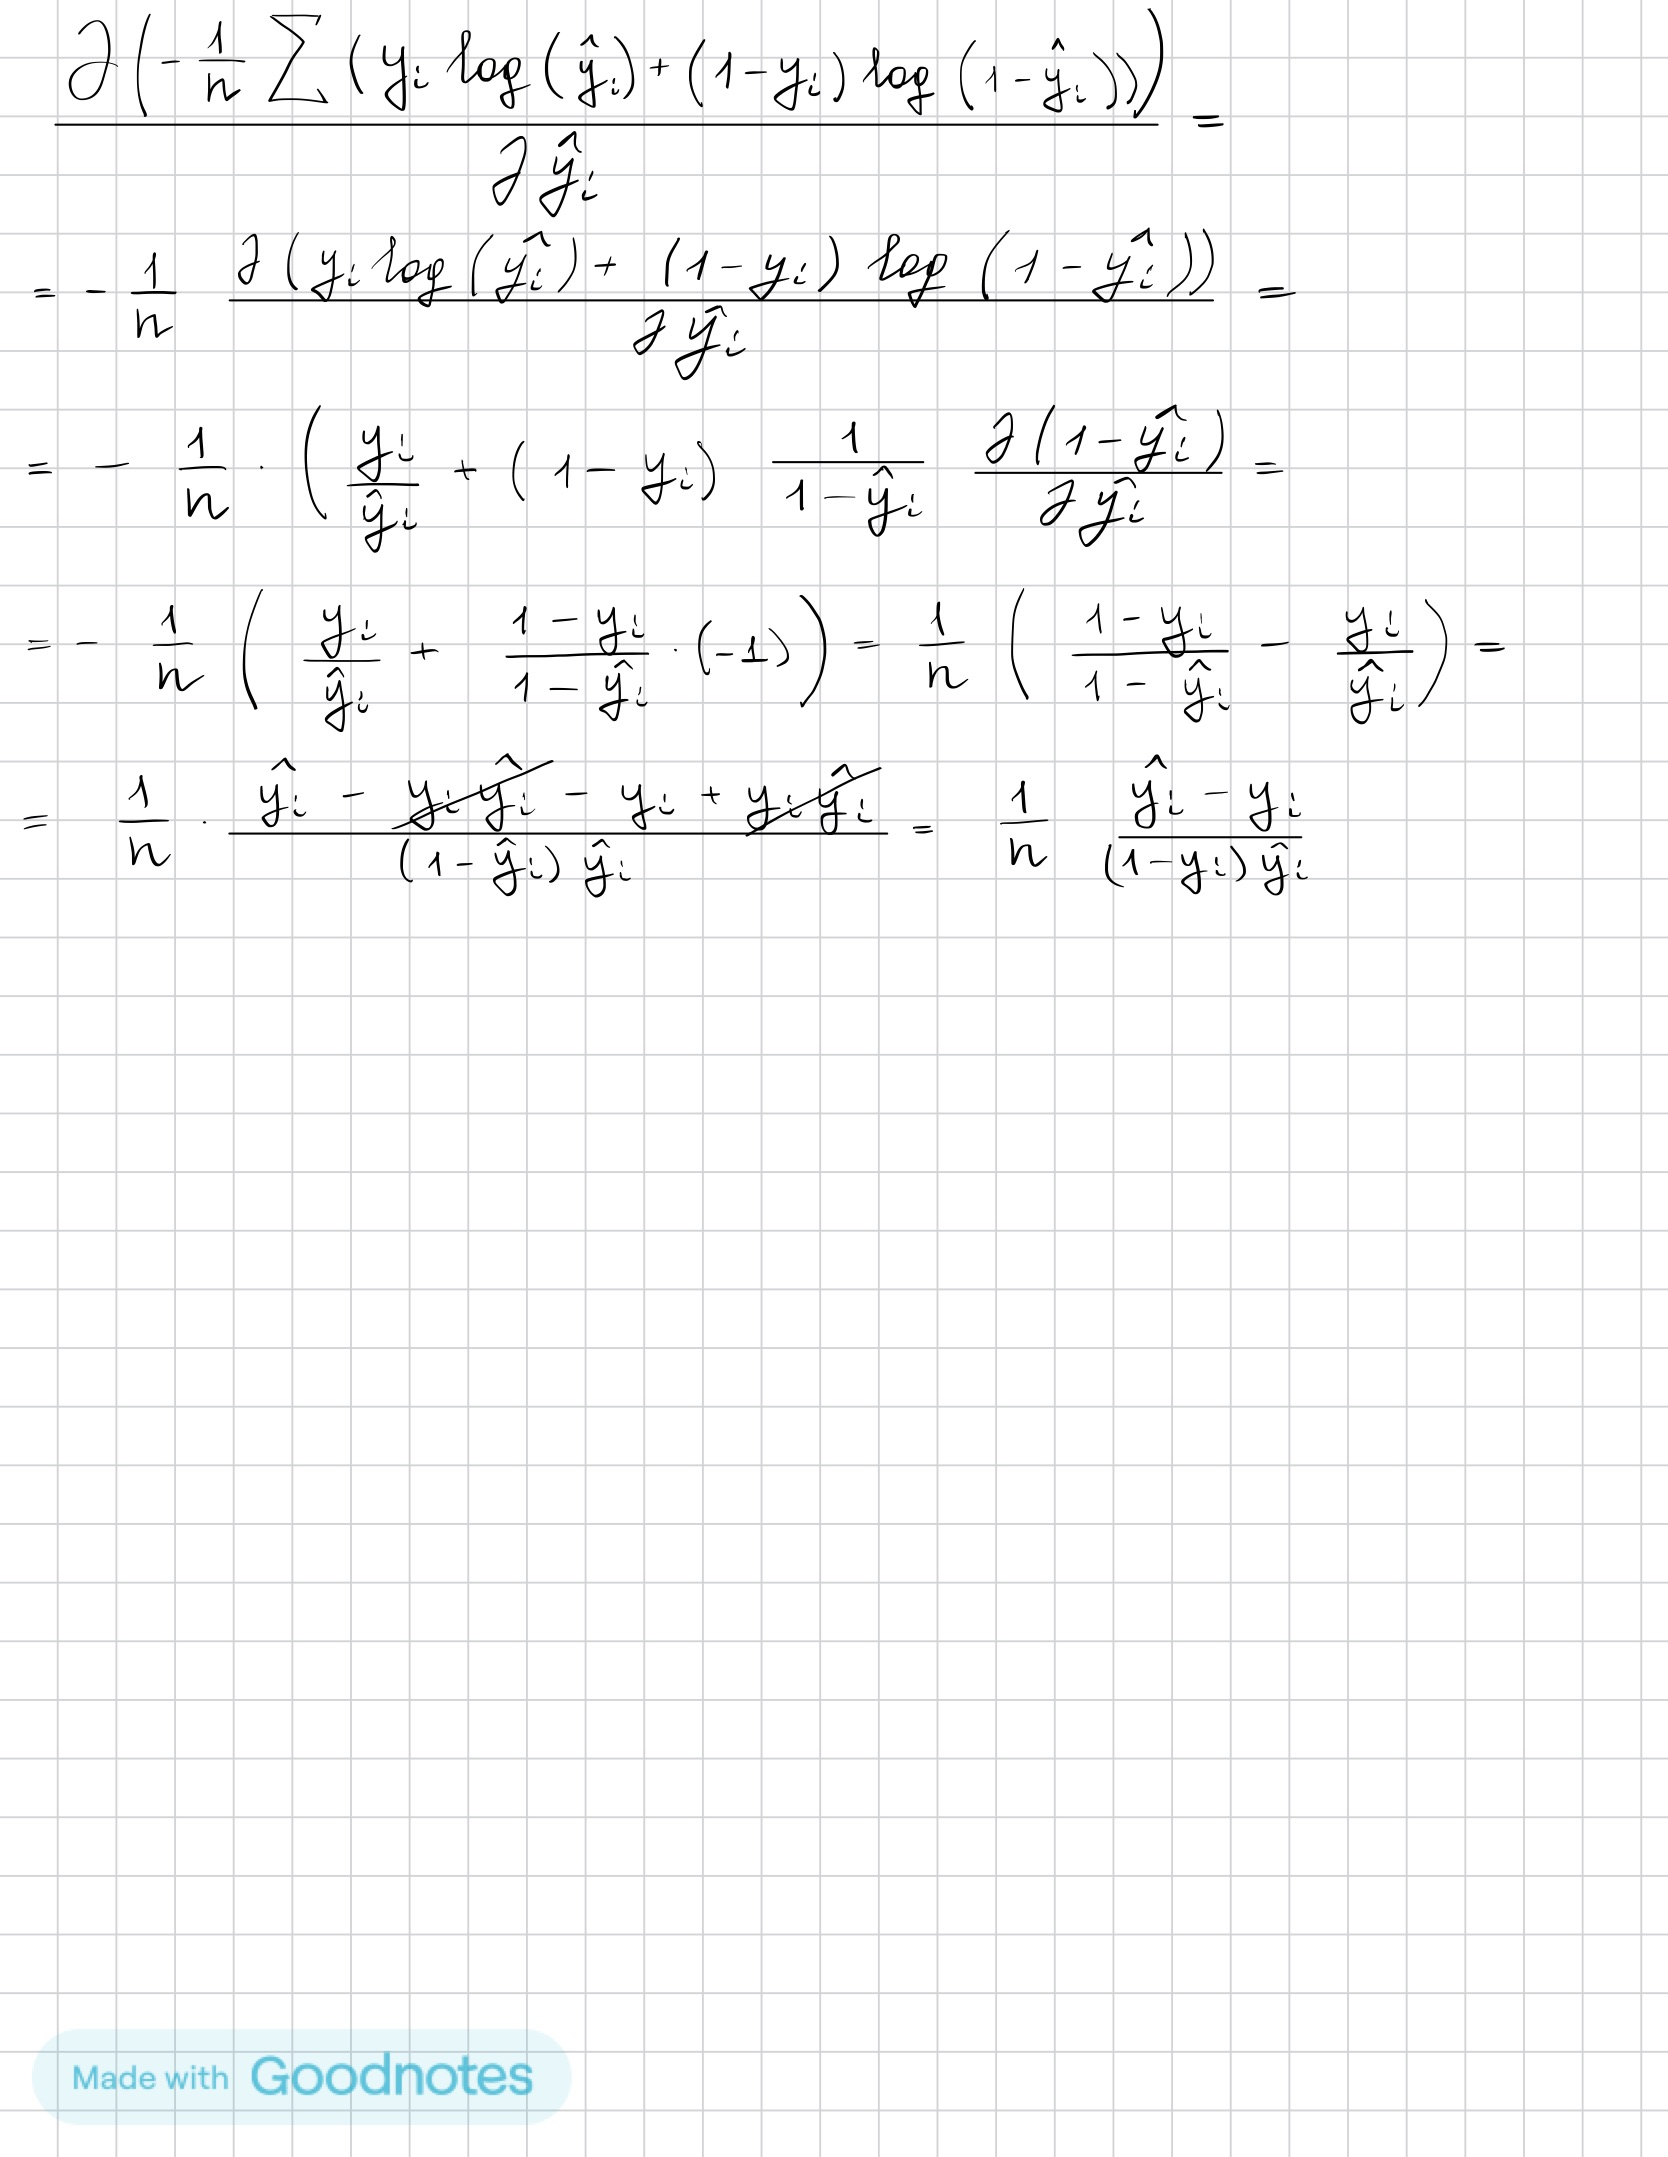

In [27]:
class BinaryCrossEntropy(LossFunction):
    def __call__(self, targets: np.ndarray, outputs: np.ndarray) -> float:
        """Вычисляет бинарную кросс-энтропию"""
        # Добавляем эпсилон для численной стабильности
        epsilon = 1e-12
        outputs = np.clip(outputs, epsilon, 1. - epsilon)
        return -np.mean(targets * np.log(outputs) + (1 - targets) * np.log(1 - outputs))

    def grad(self, targets: np.ndarray, outputs: np.ndarray) -> np.ndarray:
        """Вычисляет градиент бинарной кросс-энтропии"""
        epsilon = 1e-12
        outputs = np.clip(outputs, epsilon, 1. - epsilon)
        return (outputs - targets) / (outputs * (1 - outputs)) / len(targets)

Сверим свою реализацию с реализацией из PyTorch.

In [28]:
targets = np.array([0, 1, 1, 0, 1])
logits = np.array([0.3, 0.7, 0.8, 0.2, 0.6])

# Custom implementation
custom_loss = BinaryCrossEntropy()
custom_loss_value = custom_loss(targets, logits)
custom_loss_grad = custom_loss.grad(targets, logits)

# PyTorch implementation
targets_torch = torch.tensor(targets, dtype=torch.float32)
logits_torch = torch.tensor(logits, dtype=torch.float32, requires_grad=True)
torch_loss_function = nn.BCELoss()
torch_loss_value = torch_loss_function(logits_torch, targets_torch)
torch_loss_value.backward()
torch_loss_value = torch_loss_value.item()
torch_loss_grad = logits_torch.grad.numpy()

# Compare results
print("Custom Loss Value:", custom_loss_value)
print("PyTorch Loss Value:", torch_loss_value)
print("Custom Loss Gradient:", custom_loss_grad)
print("PyTorch Loss Gradient:", torch_loss_grad)

assert np.isclose(custom_loss_value, torch_loss_value) and np.allclose(custom_loss_grad, torch_loss_grad)

Custom Loss Value: 0.334092522854375
PyTorch Loss Value: 0.33409252762794495
Custom Loss Gradient: [ 0.28571429 -0.28571429 -0.25        0.25       -0.33333333]
PyTorch Loss Gradient: [ 0.2857143  -0.2857143  -0.25        0.24999997 -0.3333333 ]


### Cross-Entropy

В задачах классификации категориальная кросс-энтропия используется как функция потерь для оценки разницы между предсказанными вероятностями классов и истинными метками классов.

Пусть у нас есть $ K $ классов, и для каждого примера $ i $ имеются предсказанные вероятности $ p_{i1}, p_{i2}, ..., p_{iK} $ для каждого класса. И пусть $ y_{ij} $ обозначает индикаторную переменную, которая равна 1, если пример $ i $ относится к классу $ j $, и 0 в противном случае.

Формула для категориальной кросс-энтропии выглядит следующим образом:

$
\text{Cross-entropy} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \log(p_{ij})
$

Эта формула измеряет среднюю "удалённость" между истинными метками $ y_{ij} $ и предсказанными вероятностями $ p_{ij} $. Она стремится к нулю, когда предсказанные вероятности близки к истинным меткам для всех примеров.

Градиент мультиклассовой кросс-энтропии по отношению к предсказанным вероятностям вычисляется следующим образом:

$
\frac{\partial \text{Cross-entropy}}{\partial p_{ij}} = -\frac{1}{N} \frac{y_{ij}}{p_{ij}}
$

Градиент показывает, как изменение вероятности $ p_{ij} $ влияет на значение функции потерь. Градиент стремится к бесконечности, когда предсказанная вероятность стремится к 0, и к нулю, когда предсказанная вероятность стремится к 1.

In [29]:
import numpy as np
from abc import ABC, abstractmethod

class CrossEntropy:
    def __init__(self, use_softmax: bool = True, epsilon: float = 1e-7):
        self.use_softmax = use_softmax
        self.epsilon = epsilon

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def __call__(self, targets: np.ndarray, outputs: np.ndarray) -> float:
        if self.use_softmax:
            outputs = self.softmax(outputs)

        outputs = np.clip(outputs, self.epsilon, 1. - self.epsilon)
        batch_size = outputs.shape[0]
        return -np.sum(targets * np.log(outputs)) / batch_size

    def grad(self, targets: np.ndarray, outputs: np.ndarray) -> np.ndarray:
        if self.use_softmax:
            outputs = self.softmax(outputs)
            return (outputs - targets) / targets.shape[0]
        else:
            outputs = np.clip(outputs, self.epsilon, 1. - self.epsilon)
            return (-targets / outputs) / targets.shape[0]

Сверим свою реализацию с реализацией из PyTorch. В данной реализации к входным данным по умолчанию применяется Softmax.

In [30]:
targets = np.array([2, 0, 1, 4, 3])
targets_one_hot = np.eye(5)[targets]

logits = np.array([[0.42194493, 0.11111515, 0.2331985,  0.1709079,  0.06283352],
                   [0.50811597, 0.380799,   0.58517274, 0.44421673, 0.12969366],
                   [0.01138442, 0.12280621, 0.87035961, 0.74922558, 0.8304247],
                   [0.87531709, 0.34677379, 0.06201914, 0.52324805, 0.75431726],
                   [0.49000835, 0.98996684, 0.69016974, 0.70180657, 0.23664727]])

# Ваша реализация (с use_softmax=True)
custom_loss = CrossEntropy(use_softmax=True)
custom_loss_value = custom_loss(targets_one_hot, logits)
custom_loss_grad = custom_loss.grad(targets_one_hot, logits)

# PyTorch реализация
targets_torch = torch.tensor(targets)
logits_torch = torch.tensor(logits, dtype=torch.float32, requires_grad=True)
torch_loss_function = nn.CrossEntropyLoss()
torch_loss_value = torch_loss_function(logits_torch, targets_torch)
torch_loss_value.backward()
torch_loss_value = torch_loss_value.item()
torch_loss_grad = logits_torch.grad.numpy()

# Вывод результатов
print("Custom Loss Value:", custom_loss_value)
print("PyTorch Loss Value:", torch_loss_value)
print("Custom Loss Gradient:\n", custom_loss_grad)
print("PyTorch Loss Gradient:\n", torch_loss_grad)

assert np.isclose(custom_loss_value, torch_loss_value) and np.allclose(custom_loss_grad, torch_loss_grad)

Custom Loss Value: 1.6285315044458577
PyTorch Loss Value: 1.6285316944122314
Custom Loss Gradient:
 [[ 0.0495402   0.03630497 -0.15898089  0.03854196  0.03459375]
 [-0.15636616  0.03841761  0.04712906  0.04093288  0.02988661]
 [ 0.02262867 -0.17470417  0.05342042  0.04732596  0.05132911]
 [ 0.05521625  0.03254794  0.02448252  0.03882981 -0.15107652]
 [ 0.03400008  0.05605433  0.0415345  -0.15797935  0.02639044]]
PyTorch Loss Gradient:
 [[ 0.0495402   0.03630498 -0.15898089  0.03854196  0.03459375]
 [-0.15636617  0.03841761  0.04712906  0.04093289  0.02988662]
 [ 0.02262867 -0.17470416  0.05342041  0.04732596  0.05132911]
 [ 0.05521625  0.03254793  0.02448252  0.03882981 -0.15107653]
 [ 0.03400008  0.05605434  0.04153449 -0.15797935  0.02639044]]


## Полносвязная нейронная сеть (4 балла)

Как уже говорилось, нейронная сеть состоит из слоев, слои состоят из нейронов. В данной работе мы рассмотрим только простейший линейный слой. В нашей конфигурации сети функция активации будет "зашита" в слой.

Итак, создадим полносвязную нейронную сеть, состояющую из последовательных слоев с функциями активации.


**Прямой проход (forward pass)**

Прямой проход по сети будет представлять собой последовательный вызов forward pass-а каждого слоя сети.

На каждом слое происходит следующее:

Входные данные $ X $ умножаются на матрицу весов $ W $ и добавляется смещение $ b $, поверх также применяется функция активации, чтобы получить выход $ Z $.

$
Z = Activation(XW + b)
$

Здесь $ X $ - матрица входных данных размерности $ (m, n) $, $ W $ - матрица весов размерности $ (n, p) $, $ b $ - вектор смещений размерности $ (1, p) $, а $ Z $ - выходной вектор размерности $ (m, p) $.

При первоначальной инициализации слоя будем задавать веса случайным образом. Вопрос инициализации весов в целом достаточно нетривиальный, так как начальное положение влияет на сходимость сети.

**Обратный проход (backward pass)**

Обратный обход по сети будет выглядеть следующим образом:

Сначала найти градиент функции потерь по выходу сети $Y$, то есть $ \frac{\partial L}{\partial Y} $.

Затем пройти по всем слоям в обратном порядке, для каждого слоя найти градиенты и обновить параметры слоя.

1. Градиент по выходам $ \frac{\partial L}{\partial Z} $ рассчитывается как произведение градиента функции потерь $ \frac{\partial L}{\partial Y} $ и градиента функции активации $ \frac{\partial Y}{\partial Z} $

  $ \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial Z} $

2. Градиент по входам $ \frac{\partial L}{\partial X} $ вычисляется как произведение градиента по выходам $ \frac{\partial L}{\partial Z} $ и транспонированной матрицы весов $ W^T $

   $
   \frac{\partial L}{\partial X} = \frac{\partial L}{\partial Z} W^T
   $

3. Градиент по весам $\frac{\partial L}{\partial W}$ вычисляется как произведение транспонированной матрицы входов $X^T$ и градиента по выходам $ \frac{\partial L}{\partial Z}$

   $
   \frac{\partial L}{\partial W} = X^T \frac{\partial L}{\partial Z}
   $

4. Градиент по смещениям $ \frac{\partial L}{\partial b} $ вычисляется как сумма
   градиента по выходам $ \frac{\partial L}{\partial Z} $ по столбцам

   $
   \frac{\partial L}{\partial b} = \sum_{i=1}^{m} \frac{\partial L}{\partial z_i}
   $

   Где $ L $ - функция потерь, $ z_i $ - i-ый элемент выходного вектора $ Z $

5. Параметры $ W $ и $ b $ обновляются с использованием градиентного спуска:

   $
   W = W - \eta \frac{\partial L}{\partial W}
   $

   $
   b = b - \eta \frac{\partial L}{\partial b}
   $

   Где $ \eta $ - скорость обучения (learning rate)

6. Текущий градиент по входам $ \frac{\partial L}{\partial X} $ становится своего рода градиентом функции потерь $ \frac{\partial L}{\partial Y} $ для последующего слоя

In [31]:
import numpy as np
from typing import Optional
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [32]:
class Layer:
    def __init__(self, input_size: int, output_size: int, activation: ActivationFunction=Identity(), random_seed: int=17):
        if random_seed is not None:
            np.random.seed(random_seed)  # в колабе распространяется только на текущую ячейку
        self.W = np.random.randn(input_size, output_size)  * 0.1
        self.b = np.zeros((1, output_size))
        self.activation = activation
        self.inputs = None
        self.outputs = None

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        self.inputs = inputs
        Z = inputs @ self.W + self.b
        self.outputs = self.activation(Z)
        return self.outputs

    def backward(self, grad_outputs: np.ndarray, learning_rate: int=0.01) -> np.ndarray:
        grad_Z = grad_outputs * self.activation.grad(self.outputs)
        grad_W = self.inputs.T @ grad_Z
        grad_b = np.sum(grad_Z, axis=0, keepdims=True)

        self.W -= learning_rate * grad_W
        self.b -= learning_rate * grad_b

        return grad_Z @ self.W.T

In [33]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer], loss: LossFunction):
        self.layers = layers
        self.loss = loss

    def forward(self, X: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, outputs: np.ndarray, targets: np.ndarray, learning_rate: int=0.01):
        loss_grad = self.loss.grad(targets = targets, outputs = outputs)
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad, learning_rate)

    def train(self, X: np.ndarray, y: np.ndarray, epochs: int=1000, learning_rate: int=0.01) -> np.ndarray:
        loss_history = []
        for epoch in range(epochs):
            outputs = self.forward(X)
            loss = self.loss(targets = y, outputs = outputs)
            loss_history.append(loss)
            self.backward(outputs, y, learning_rate)
        return loss_history

Посмотрим, как работает наша нейронная сеть, на игрушечных примерах.

### Регрессия

MSE: 0.011090609683464876


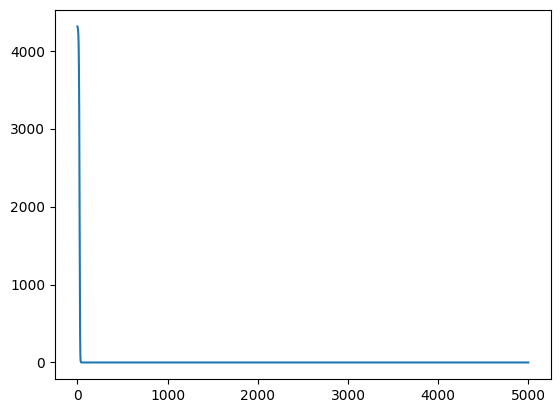

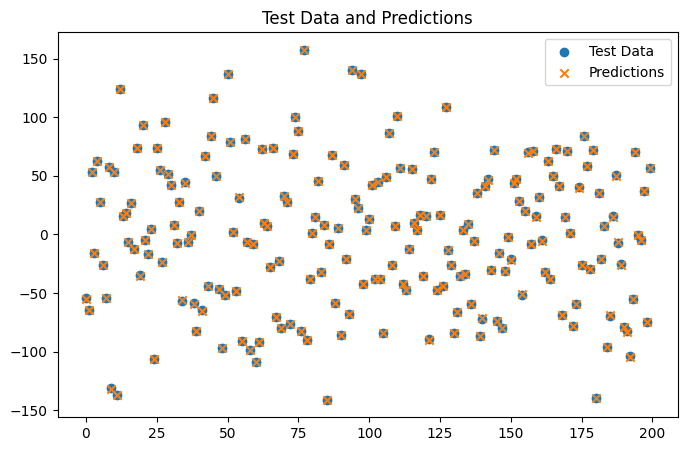

In [34]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


X, y = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layers = [
    Layer(5, 10, activation=Identity()),
    Layer(10, 1, activation=Identity())
]
model = NeuralNetwork(layers, loss=MeanSquaredError())

losses = model.train(X_train, y_train, epochs=5000, learning_rate=0.001)
y_pred = model.forward(X_test)

print("MSE:", MeanSquaredError()(y_test, y_pred))
plt.plot(losses)
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Test Data and Predictions')
plt.scatter(range(len(y_test)), y=y_test, label='Test Data')
plt.scatter(range(len(y_test)), y=y_pred, marker='x', label='Predictions')
plt.legend(loc='best');

### Классификация

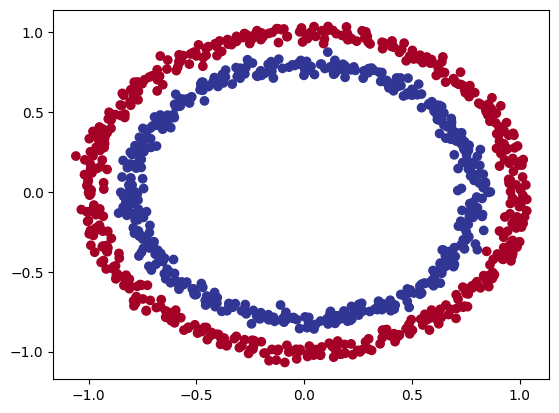

In [35]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score


n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
y = y.reshape(-1, 1)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Запустите следующие две ячейки. У вас должны получиться похожие результаты. Письменно объясните, почему вторая нейронная сеть на таких данных отрабатывает значительно лучше первой.

Accuracy: 0.46


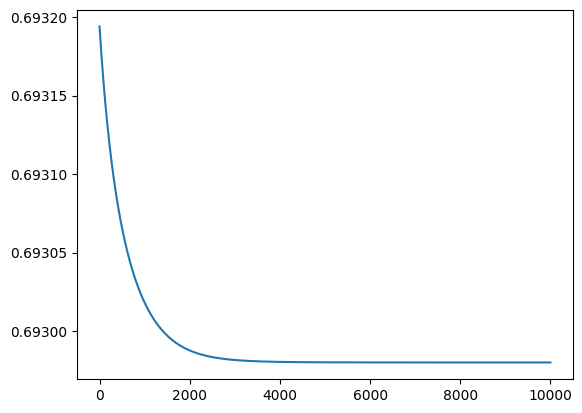

In [37]:
layers = [
    Layer(2, 5, activation=Identity()),
    Layer(5, 1, activation=Sigmoid())
]
model = NeuralNetwork(layers, loss=BinaryCrossEntropy())

losses = model.train(X_train, y_train, epochs=10000, learning_rate=0.1)
y_pred = model.forward(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred.round()))
plt.plot(losses);

Accuracy: 0.8


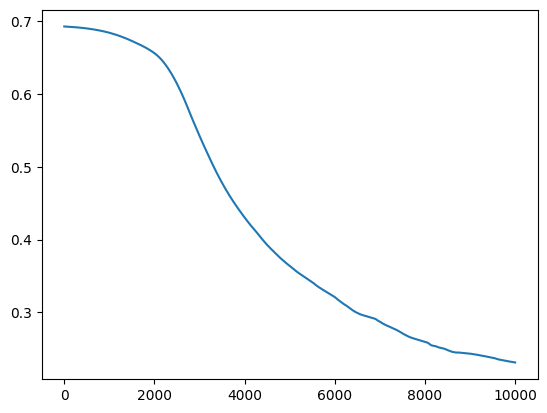

In [38]:
layers = [
    Layer(2, 5, activation=ReLU()),
    Layer(5, 1, activation=Sigmoid())
]
model = NeuralNetwork(layers, loss=BinaryCrossEntropy())

losses = model.train(X_train, y_train, epochs=10000, learning_rate=0.1)
y_pred = model.forward(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred.round()))
plt.plot(losses);

**Почему второй пример намного точнее?**

Классы нелинейно разделимы — ни одна прямая линия не может разделить их без ошибок. Для решения такой задачи нужна модель, способная уловить нелинейные зависимости (например, нейронная сеть с активацией ReLU или SVM с RBF-ядром).


В данных нейронных сетях использованы разные функции активации: в первой сети - Identity (линейная), во второй - ReLu (нелинейная). Также на выходном слое активируется Sigmoid

Identity-функция (тождественная) не вносит нелинейность в сеть. Комбинация линейных слоёв эквивалентна одному линейному преобразованию, поэтому сеть с Identity не может решать сложные нелинейные задачи.

ReLU — нелинейная функция, позволяющая сети обучаться сложным паттернам. Она особенно эффективна в скрытых слоях, так как сохраняет способность к обучению глубоких сетей.

2. Проблема "исчезающих градиентов"
В первой сети (с Identity) градиенты при обратном распространении остаются неизменными, что может приводить к медленному обучению.

ReLU избегает этой проблемы для положительных значений, так как её производная равна 1 при x>0. Это ускоряет обучение и улучшает передачу градиентов.

3. Активация Sigmoid на выходе
Sigmoid (на выходном слое) сжимает значения в диапазон [0,1], что подходит для бинарной классификации. Однако без нелинейностей в скрытых слоях сеть не может построить полезные признаки для Sigmoid. ReLU же помогает создать осмысленные признаки перед финальным преобразованием.

Первая сеть с Identity фактически является линейной моделью, поэтому её точность близка к случайному угадыванию на сложных данных.

Вторая сеть с ReLU:

-Моделирует нелинейные зависимости в данных.

-Обучается быстрее и достигает лучшей точности.


-Избегает проблем с градиентами, характерных для Identity.



Самостоятельно реализуйте нейронную сеть для следующего набора данных. Ориентируйтесь на accuracy > 90%

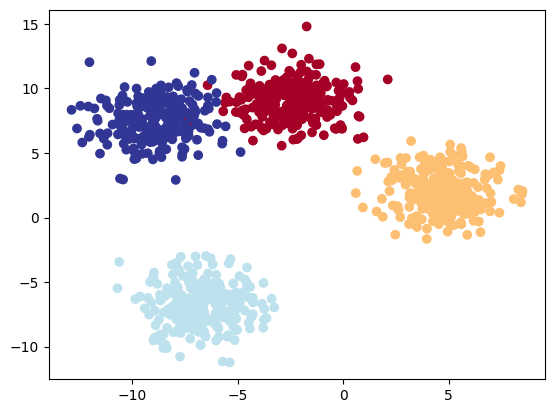

In [39]:
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=1000,
    n_features=2,
    centers=4,
    cluster_std=1.5,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [46]:
y_train[:10]

array([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])

In [45]:
num_classes = 4
y_train_v = np.eye(num_classes)[y_train]
y_train_v[0]

array([0., 1., 0., 0.])

Accuracy: 0.99


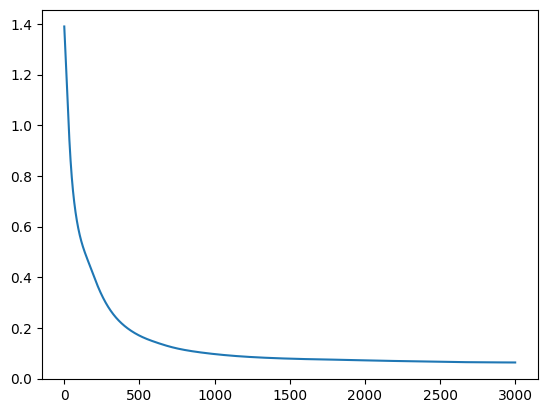

In [47]:
layers = [
    Layer(2, 6, activation=Sigmoid()),
    Layer(6, 4, activation=Identity())
]
model = NeuralNetwork(layers, loss=CrossEntropy(use_softmax = True))

losses = model.train(X_train, y_train_v, epochs=3000, learning_rate=0.1)
y_pred = model.forward(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
plt.plot(losses);

## Задание (4 балла)

Самостоятельно найдите какой-либо датасет для задачи, которую потенциально можно решить с помощью вашей реализации нейронной сети (регрессия или классификация).

Создайте сеть, обучите её, оцените качество модели.

Где можно найти датасеты:

* [Google Dataset Search](https://datasetsearch.research.google.com/) - базовый поисковик, может не подойти для узких задач.
* [Re3Data](https://www.re3data.org/) - поисковик. Поиск по ключевым словам работает довольно плохо, зато есть возможность искать по структурированным областям знания.
* [World Bank](https://datacatalog.worldbank.org/home) - еще один поисковик. Содержит не очень большое количество датасетов.
* [Papers with Code](https://paperswithcode.com/datasets) - платформа, содержащая не только датасеты, но и информацию об их использовании в различных исследованиях.
* [Kaggle](https://www.kaggle.com/datasets) - платформа AI & ML сообщества. Можно найти как датасеты, так и работы (в том числе любительского уровня), в которых эти датасеты используются.
* [HuggingFace](https://huggingface.co/datasets) - платформа AI сообщества. Предоставляет удобный интерфейс для доступа к датасетам. Также можно изучить open-source модели, обученные на этих датасетах.
* [GitHub](https://github.com/awesomedata/awesome-public-datasets) - на Гитхабе трудно найти датасеты из-за ограничения на максимальный объем загружаемых файлов, однако люди часто делают подборки со сслыками на другие ресурсы.
* [Humanitarian Data Exchange](https://data.humdata.org/) - платформа для обмена данными, связанными с гуманитаристикой.
* [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) - небольшая платформа с датасетами. Для части датасетов предоставляется импорт с помощью Python.
